In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

In [20]:
file_path = 'cabin_bookings.csv'
df = pd.read_csv(file_path)

In [21]:
df = df.dropna()

In [22]:
df['first_booking_date'] = pd.to_datetime(df['first_booking_date'])
df['booking_month'] = df['first_booking_date'].dt.month
df['booking_weekday'] = df['first_booking_date'].dt.weekday

In [23]:
df = pd.get_dummies(df, columns=['season'], drop_first=True)
df

,id,name,price,first_booking_date,total_bookings,booking_month,booking_weekday,season_Spring,season_Summer,season_Winter
0,0,1,299,2024-09-01,2,9,6,False,False,False
1,1,4,292,2024-09-27,4,9,4,False,False,False
2,2,2,330,2023-12-10,4,12,6,False,False,True
3,3,4,265,2023-05-02,3,5,1,True,False,False
4,4,1,267,2024-05-12,6,5,6,True,False,False
...,...,...,...,...,...,...,...,...,...,...
1995,1995,2,346,2024-03-09,9,3,5,True,False,False
1996,1996,1,246,2023-12-31,5,12,6,False,False,True
1997,1997,2,376,2023-12-26,10,12,1,False,False,True
1998,1998,3,356,2023-04-28,6,4,4,True,False,False


In [24]:
X = df.drop(columns=['price', 'first_booking_date'])
y = df['price']

In [25]:
scaler = StandardScaler()
X[['total_bookings']] = scaler.fit_transform(X[['total_bookings']])


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

MAE: 17.933949999999996
RMSE: 21.271160558371044


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


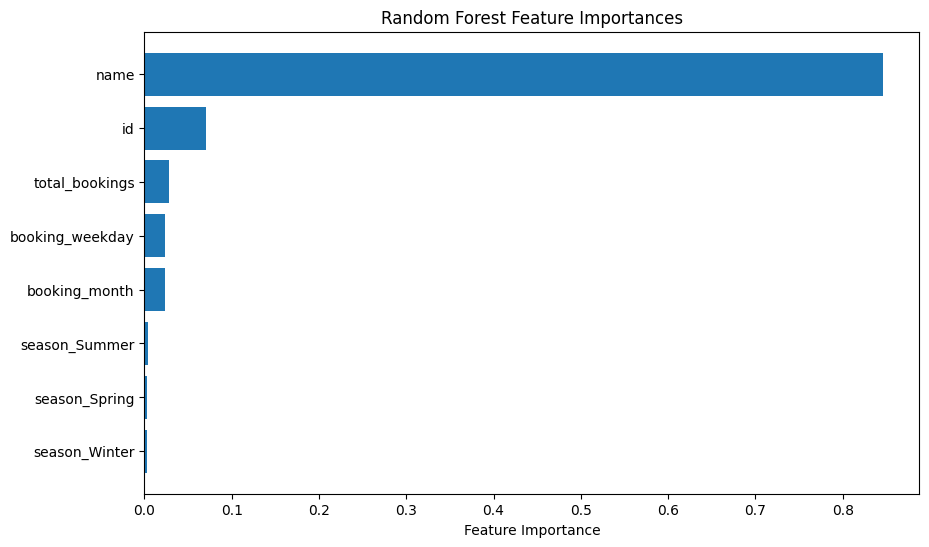

In [28]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

In [29]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [30]:
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error'
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_best = best_model.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("Best Model MAE:", mean_absolute_error(y_test, y_pred_best))
print("Best Model RMSE:", mean_squared_error(y_test, y_pred_best, squared=False))
print("Best Model R2 Score:", r2_score(y_test, y_pred_best))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Model MAE: 17.714584274759
Best Model RMSE: 20.864233940376767
Best Model R2 Score: 0.840995636987614


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-cv_scores.mean():.2f}")


Cross-validation MAE: 18.64


In [32]:
print(f"Cross-validation MAE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Cross-validation MAE: 18.64 ± 1.00


In [33]:
import joblib
joblib.dump(best_model, 'price_prediction_model.pkl')


['price_prediction_model.pkl']

In [34]:
import joblib

loaded_model = joblib.load('price_prediction_model.pkl')

y_loaded_pred = loaded_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("MAE from loaded model:", mean_absolute_error(y_test, y_loaded_pred))


MAE from loaded model: 17.714584274759


In [36]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

model = joblib.load('price_prediction_model.pkl')

scaler = StandardScaler()
scaler.fit(X[['total_bookings']])

new_data = pd.DataFrame({
    'id': [2001],
    'name': [3],
    'first_booking_date': ['2023-07-07'],
    'total_bookings': [5],
    'season': ['Summer']
})

new_data['first_booking_date'] = pd.to_datetime(new_data['first_booking_date'])
new_data['booking_month'] = new_data['first_booking_date'].dt.month
new_data['booking_weekday'] = new_data['first_booking_date'].dt.weekday
new_data = pd.get_dummies(new_data, columns=['season'], drop_first=True)

for col in X.columns:
    if col not in new_data.columns and col != 'price':
        new_data[col] = 0

new_data = new_data[X.columns]

new_data[['total_bookings']] = scaler.transform(new_data[['total_bookings']])

predicted_price = model.predict(new_data)

print(f"Predicted Price: {predicted_price[0]}")


Predicted Price: 361.01678861114635
